# Financing education

In [54]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
sns.set()

warnings.filterwarnings('ignore')

# import the data
df = pd.read_csv('data/education_financing/base.csv')
gdp = pd.read_csv('data/education_financing/gdp.csv')
pop = pd.read_csv('data/education_financing/population.csv')

# functions needed later
def count_missing(frame):
    return (frame.shape[0] * frame.shape[1]) - frame.count().sum()

def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

In [55]:
df.head()

,Time,Time Code,Country Name,Country Code,Government expenditure on pre-primary education as % of GDP (%) [UIS.XGDP.0.FSGOV],Government expenditure on primary education as % of GDP (%) [UIS.XGDP.1.FSGOV],Government expenditure on secondary education as % of GDP (%) [UIS.XGDP.23.FSGOV],Government expenditure on tertiary education as % of GDP (%) [UIS.XGDP.56.FSGOV],"Government expenditure on pre-primary education, US$ (millions) [UIS.X.US.02.FSGOV]","Government expenditure on primary education, US$ (millions) [UIS.X.US.1.FSGOV]","Government expenditure on secondary education, US$ (millions) [UIS.X.US.2T3.FSGOV]","Government expenditure on tertiary education, US$ (millions) [UIS.X.US.5T8.FSGOV]","Government expenditure on education, US$ (millions) [UIS.X.US.FSGOV]",All staff compensation as % of total expenditure in primary public institutions (%) [UIS.XSPENDP.1.FDPUB.FNS],Capital expenditure as % of total expenditure in primary public institutions (%) [UIS.XSPENDP.1.FDPUB.FNCAP],Teaching staff compensation as a percentage of total expenditure in primary public institutions (%) [UIS.XSPENDP.1.FDPUB.FNTS]
0,2010,YR2010,Afghanistan,AFG,0,2.16201,0.9288,0.31427,0,342.82052,147.27517,49.83245,551.72194,75.46723,17.33474,64.90182
1,2010,YR2010,Albania,ALB,..,..,..,..,..,..,..,..,..,..,..,..
2,2010,YR2010,Algeria,DZA,..,..,..,..,..,..,..,..,..,..,..,..
3,2010,YR2010,American Samoa,ASM,..,..,..,..,..,..,..,..,..,..,..,..
4,2010,YR2010,Andorra,AND,0.43487,0.86011,0.62315,0.11494,15.00276,29.67335,21.49835,3.96527,102.69286,45.43353,2.22619,40.53243


## Data cleaning

In [56]:
# removing the rows that did not had country names or code, dropping unnecessary columns
df = df.replace('..', float("NaN"))

df.drop(['Time Code', 'Teaching staff compensation as a percentage of total expenditure in primary public institutions (%) [UIS.XSPENDP.1.FDPUB.FNTS]'], axis=1, inplace=True)

df = df[df['Country Name'].notna()]
df = df[df['Country Code'].notna()]

df['Time'] = df['Time'].apply(lambda x:int(x))

# renaming the columns 
df.columns = ['Year','Entity', 'Code',
       'gov_exp_pre_primary (% of GDP)',
       'gov_exp_primary (% of GDP)',
       'gov_exp_secondary (% of GDP)',
       'gov_exp_tertiary (% of GDP)',
       'gov_exp_pre_primary (US $ millions)',
       'gov_exp_primary (US $ millions)',
       'gov_exp_secondary (US $ millions)',
       'gov_exp_tertiary (US $ millions)',
       'gov_exp_all_levels (US $ millions)',
       'all_staff_compensation_primary',
       'capital_exp_primary']

df.sort_values(by=['Year'], inplace=True)
df.set_index(['Entity', 'Code', 'Year'], inplace=True)

# keeping the country that had most of the data available
countries_keep = df.groupby('Entity').apply(count_missing).sort_values().index.values[:120]

df.reset_index(inplace=True)
df = df.loc[df['Entity'].isin(countries_keep)]
df.set_index(['Entity', 'Code', 'Year'], inplace=True)

# keeping the rows that had most of the data available
perc = 60.0
min_count =  int(((100-perc)/100)*df.shape[1] + 1)
df = df.dropna( axis=0, 
                    thresh=min_count)

# creating a categorical variable to add information whether the country is in the oecd organization
oecd = ["Austria", "Australia", "Belgium", "Canada", "Chile", "Colombia", "Costa Rica", "Czech Republic", "Denmark", "Estonia", "Finland", "France", "Germany", "Greece", "Hungary", "Iceland", "Ireland", "Israel", "Italy", "Japan", "South Korea", "Latvia", "Lithuania", "Luxembourg", "Mexico", "Netherlands", "New Zealand", "Norway", "Poland", "Portugal", "Slovakia", "Slovenia", "Spain", "Sweden", "Switzerland", "Turkey", "United Kingdom", "United States"]

df.reset_index(inplace=True)
df['oecd'] = df['Entity'].apply(lambda x: 1 if x in oecd else 0)
df.set_index(['Entity', 'Code', 'Year'], inplace=True)

# cleaning the gdp data set
gdp.drop(['Series Name', 'Series Code'], axis=1, inplace=True)
gdp.columns = ['Entity', 'Code', '2010', '2011',
       '2012', '2013', '2014', '2015',
       '2016', '2017', '2018', '2019',
       '2020']

gdp = gdp.melt(id_vars=["Entity", "Code"],
    var_name="Year", 
        value_name="Gdp (USD)")
gdp['Year'] = gdp['Year'].apply(lambda x:int(x))
gdp.set_index(['Entity', 'Code', 'Year'], inplace=True)
gdp.sort_values(by=['Entity', 'Year'], inplace=True)
gdp.replace('..', float("NaN"), inplace=True)
gdp.dropna(inplace=True)

# merging the gdp and base data set
df = df.join(gdp)

df = df.astype(float)
df['oecd'] = df['oecd'].apply(lambda x: int(x))

df.sort_values(by=['Entity'], inplace=True)

# clean the population data set and merge with the base data set
pop.drop(['Time Code'], axis=1, inplace=True)
pop.columns = ['Year', 'Entity', 'Code',
       'population']
pop = pop[['Entity', 'Code', 'Year', 'population']]
pop.dropna(inplace=True)
pop['Year'] = pop['Year'].apply(lambda x: int(x))
pop.set_index(['Entity', 'Code', 'Year'], inplace=True)
df = df.join(pop)

# There was one gdp value missing for South Sudan 2016 so it was added manually. 
# Data is from google. The rest of the data also match the google data.

df = df.sort_index()
df['Gdp (USD)'].loc['South Sudan', 'SSD', 2016] = 52000000000.000

# filling the missing values with mean values from different years data (same country)

countries = df.reset_index()['Entity'].unique()

na_countries = list()

for column in df.columns[:-2]:
    for country in countries:
        if((df.loc[country][column].isna().sum() > 0) and (df.loc[country].shape[0] != df.loc[country][column].isna().sum())):
            na_countries.append(country)
            df[column].loc[country].fillna(np.nanmean(df.loc[country][column].values), inplace=True)
            
# cleaning the missing values that the country had no data for that specific column, using hot deck imputation placing the
# mean value from similar gdp category countries
countries_by_gdp = df.groupby('Entity').mean().sort_values(by=['Gdp (USD)']).reset_index()
countries_by_gdp_names = countries_by_gdp['Entity'].values

countries_split = list(split(range(111), 10))

for column in df.columns[:-2]:
    for country in countries_by_gdp_names:
        for i in countries_split:
            if(country in countries_by_gdp_names[i]):
                category = i
        value = np.nanmean(df.loc[countries_by_gdp_names[category]][column].values)
        df.loc[country][column].fillna(value, inplace=True)
        
# creating the gov_exp_primary column based on population and gov_exp_primariy (US $ millions)
df["population"] = pd.to_numeric(df["population"], downcast="float")
df['gov_exp_primary_per_person (US dollars)'] = (df['gov_exp_primary (US $ millions)'] / df['population']) * 1000000

# final renaming and index setting
df.reset_index(inplace=True)
df.drop(['Entity'], axis=1, inplace=True)
df=df.rename(columns = {'Code':'country', 'Year': 'year', 'Gdp (USD)':'gdp'})
df.set_index(['country', 'year'], inplace=True)

# export the final data into csv format
df.to_csv('data/education_financing.csv')

In [57]:
# final data set
df.head()

gov_exp_pre_primary (% of GDP)  gov_exp_primary (% of GDP)  \
country year                                                               
AFG     2010                             0.0                     2.16201   
        2011                             0.0                     2.14557   
        2012                             0.0                     1.53942   
        2013                             0.0                     2.07295   
        2014                             0.0                     2.18412   

              gov_exp_secondary (% of GDP)  gov_exp_tertiary (% of GDP)  \
country year                                                              
AFG     2010                       0.92880                      0.31427   
        2011                       0.92174                      0.31110   
        2012                       0.66133                      0.33182   
        2013                       0.89054                      0.40614   
        2014                       0.93829                      0.45862   

              gov_exp_pre_primary (US $ millions)  \
country year                                        
AFG     2010                                  0.0   
        2011                                  0.0   
        2012                                  0.0   
        2013                                  0.0   
        2014                                  0.0   

              gov_exp_primary (US $ millions)  \
country year                                    
AFG     2010                        342.82052   
        2011                        382.00443   
        2012                        307.90921   
        2013                        426.22167   
        2014                        447.41375   

              gov_exp_secondary (US $ millions)  \
country year                                      
AFG     2010                          147.27517   
        2011                          164.10852   
        2012                          132.27733   
        2013                          183.10417   
        2014                          192.20826   

              gov_exp_tertiary (US $ millions)  \
country year                                     
AFG     2010                          49.83245   
        2011                          55.38973   
        2012                          66.36930   
        2013                          83.50579   
        2014                          93.94871   

              gov_exp_all_levels (US $ millions)  \
country year                                       
AFG     2010                           551.72194   
        2011                           616.38566   
        2012                           520.88233   
        2013                           710.27469   
        2014                           756.96205   

              all_staff_compensation_primary  capital_exp_primary  oecd  \
country year                                                              
AFG     2010                        75.46723             17.33474     0   
        2011                        77.44066             15.89061     0   
        2012                        81.17335             10.73619     0   
        2013                        76.45152             15.89241     0   
        2014                        76.98077             16.41255     0   

                       gdp  population  \
country year                             
AFG     2010  1.585668e+10  29185512.0   
        2011  1.780511e+10  30117412.0   
        2012  1.990732e+10  31161378.0   
        2013  2.014640e+10  32269592.0   
        2014  2.049713e+10  33370804.0   

              gov_exp_primary_per_person (US dollars)  
country year                                           
AFG     2010                                11.746257  
        2011                                12.683840  
        2012                                 9.881117  
        2013                                13.208152  
        

## Data Exploration

In [58]:
df.describe(percentiles=[])

,gov_exp_pre_primary (% of GDP),gov_exp_primary (% of GDP),gov_exp_secondary (% of GDP),gov_exp_tertiary (% of GDP),gov_exp_pre_primary (US $ millions),gov_exp_primary (US $ millions),gov_exp_secondary (US $ millions),gov_exp_tertiary (US $ millions),gov_exp_all_levels (US $ millions),all_staff_compensation_primary,capital_exp_primary,oecd,gdp,population,gov_exp_primary_per_person (US dollars)
count,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,793.000000,7.930000e+02,7.930000e+02,793.000000
mean,0.330634,1.444602,1.547545,0.929658,1488.454769,5840.649988,7669.788656,4979.260185,20256.371949,74.463990,7.509227,0.310214,4.457685e+11,3.107954e+07,240.294061
std,0.316627,0.640638,0.671189,0.530000,5090.826365,23114.439722,27156.132193,20046.707711,71893.680103,13.471017,7.202740,0.462873,1.627083e+12,9.841801e+07,336.302448
min,0.000000,0.017210,0.109130,0.000000,0.000000,7.301590,2.957430,0.000000,13.081250,0.000000,0.000000,0.000000,2.506808e+08,3.122100e+04,1.688582
50%,0.282410,1.436840,1.577620,0.903700,114.157560,623.671540,627.956690,353.486260,1905.294210,75.313546,6.074598,0.000000,4.959396e+10,9.757812e+06,111.324569
max,1.530930,7.330910,5.056270,3.240060,61662.525760,293636.197030,325625.592770,272161.343790,832820.611240,100.000000,63.744230,1.000000,1.954298e+13,1.280842e+09,1924.812838


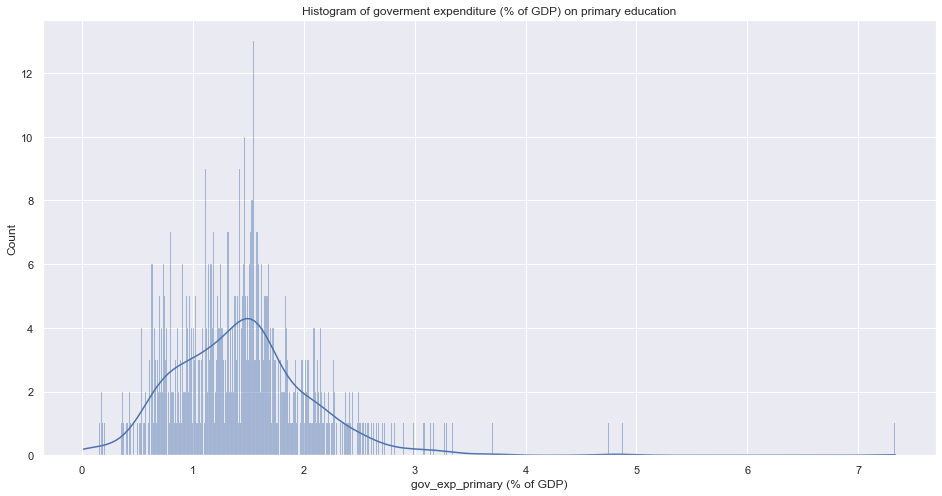

In [59]:
# gov_exp_pre_primary histogram
sns.histplot(df['gov_exp_primary (% of GDP)'], kde=True, bins=1000)
plt.title("Histogram of goverment expenditure (% of GDP) on primary education")
plt.rcParams["figure.figsize"] = (16,8)

We see from the histogram that the goverment expenditure on primary education follows a normal distributio which is expected. There are some countries that seem like outliers, those are just countries like Norway, New Zealand, who spend a lot on education.

Text(0, 0.5, 'Goverment expenditure constant US dollars (millions)')

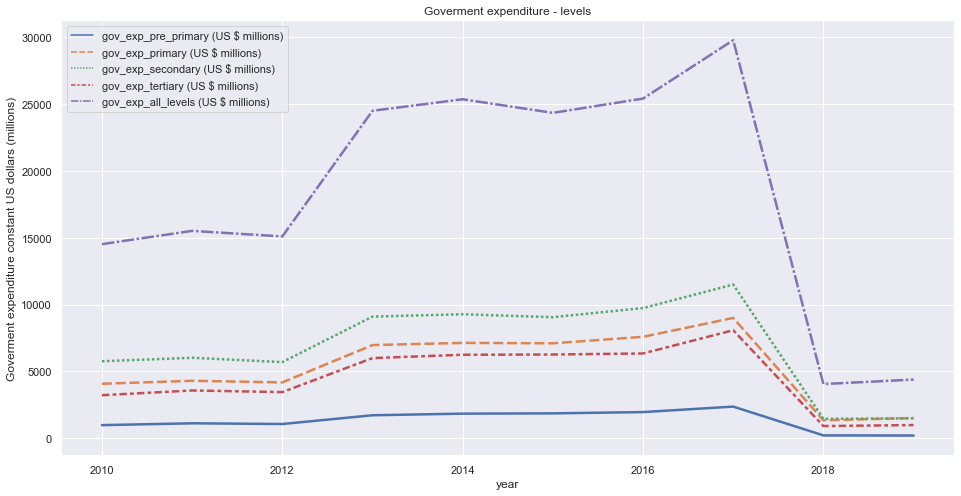

In [60]:
sns.lineplot(data=df.reset_index().groupby('year').mean().iloc[:, 4:9], linewidth = 2.5).set_title('Goverment expenditure - levels')
plt.ylabel("Goverment expenditure constant US dollars (millions)")

We see that the primary expenditure is the 2nd highest among the levels of education after secondary. In 2018, we see a big fall of in goverment spending on education as that is the year most countries cut back on spending in general.

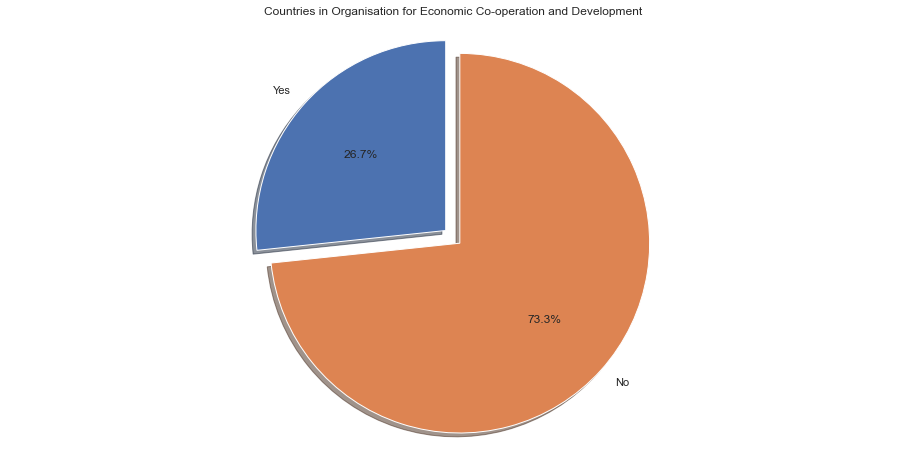

In [61]:
yes = (df.reset_index().groupby('country').mean()['oecd'].sum()/len(df.reset_index()['country'].unique())) * 100
no = 100 - yes
labels = 'Yes', 'No'
sizes = [yes, no]
explode = (0.1, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Countries in Organisation for Economic Co-operation and Development")
plt.show()

A pie chart demonstrating how many of our countries are included in Organisation for Economic Co-operation and Development which is an organisation that stimulates economic progress and world trade. The countries included are the wealthiest and most developed countries in general, so this chart is a good indicator of what countries our data consist off.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


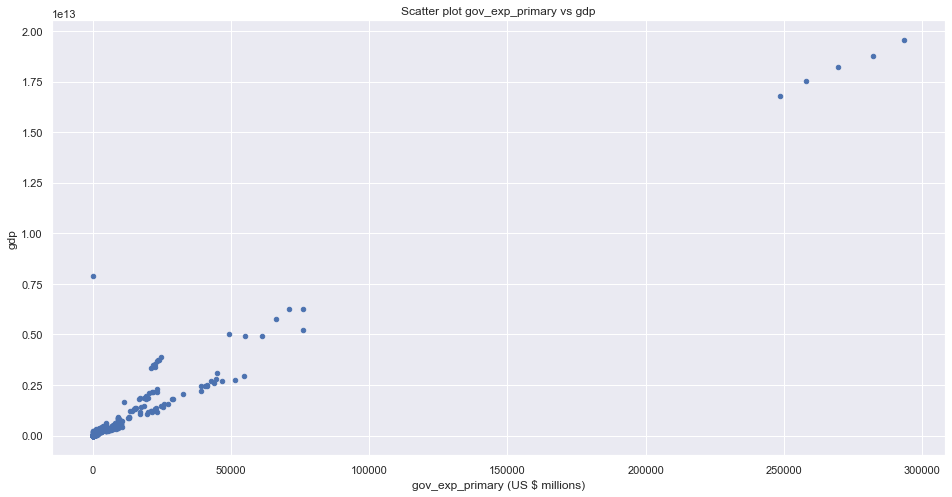

In [65]:
#scatter plot gov_exp_primary/gdp
df.plot.scatter(x='gov_exp_primary (US $ millions)', y='gdp',  title="Scatter plot gov_exp_primary vs gdp");
plt.rcParams["figure.figsize"] = (16,8)

Visualization of the expected linear relationship between gdp and goverment expenditure on primary education. At the far top right we see some points that look like outliers. Those are actually USA, Japan, UK, Germany, Brazil. The wealthies countries in our data set by far, and it is not unsual that they invest a lot in education.

## Education financing impact on primary graduation rate

In [47]:
# import the base data set, set indexes to match, take the important variable out, merge with financing_education df, drop nas
base = pd.read_csv('data/world_bank.csv')
base.set_index(['country', 'year'], inplace=True)
base = base['completion_rate']
df = pd.merge(df, base, left_index=True, right_index=True)
df.dropna(inplace=True)

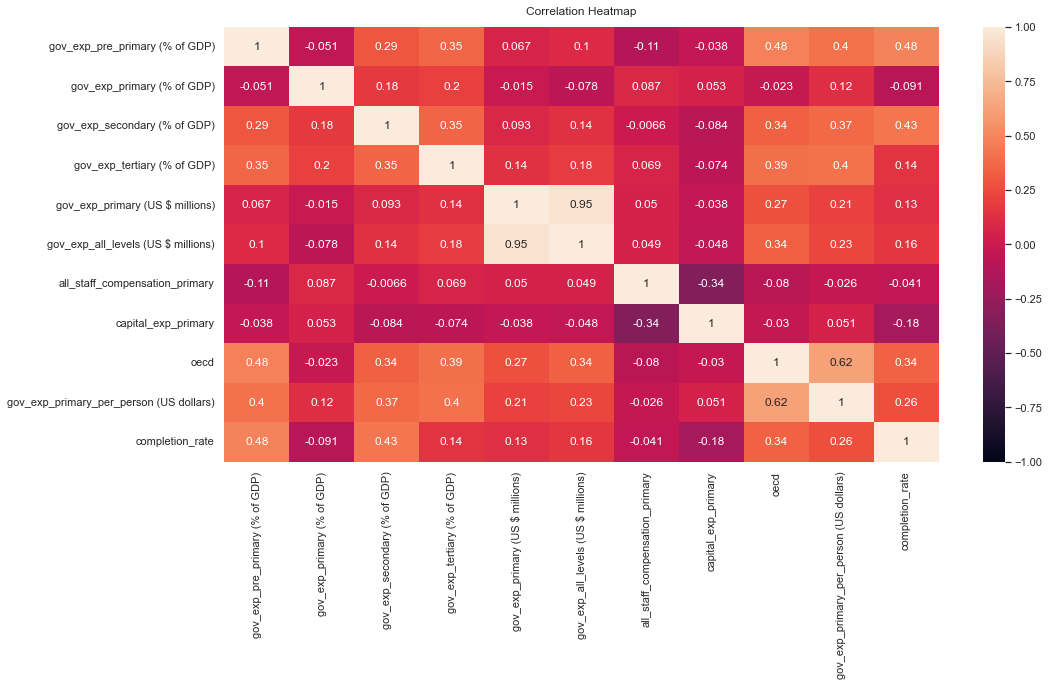

In [48]:
plt.figure(figsize=(16, 8))
heatmap = sns.heatmap(df.drop(['population', 'gdp', 'gov_exp_pre_primary (US $ millions)', 'gov_exp_secondary (US $ millions)', 'gov_exp_tertiary (US $ millions)'], axis=1).corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

From the correlation heatmap, we see that the correlation is moderately correlated with gov_exp_pre_primary, gov_exp_secondary, and oecd. The odd thing is that it is slightly negatively correlated with gov_exp_primary

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


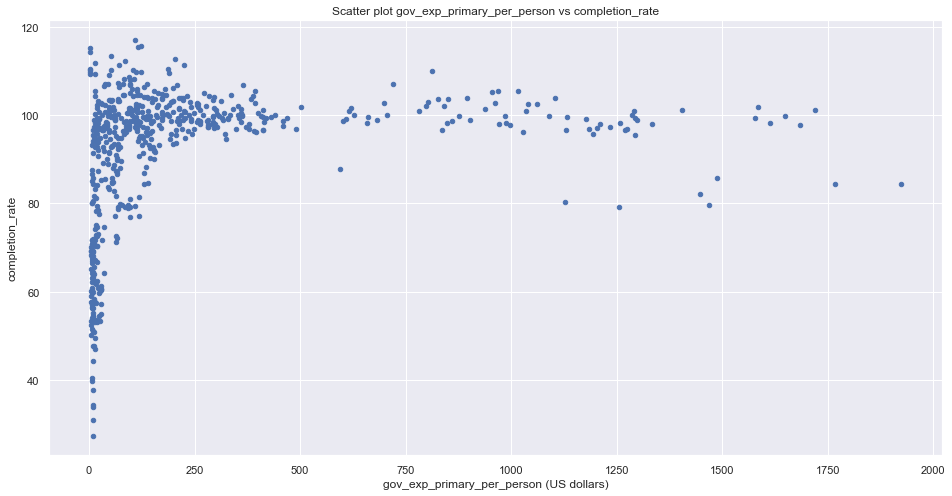

In [49]:
#scatter plot gov_exp_primary_per_person (US dollars)/completion_rate
df.plot.scatter(x='gov_exp_primary_per_person (US dollars)', y='completion_rate',  title="Scatter plot gov_exp_primary_per_person vs completion_rate");
plt.rcParams["figure.figsize"] = (16,8)

We see that as long as the goverment invests more than 100 US$ per person for primary education, the completion rate will be 80% or more.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


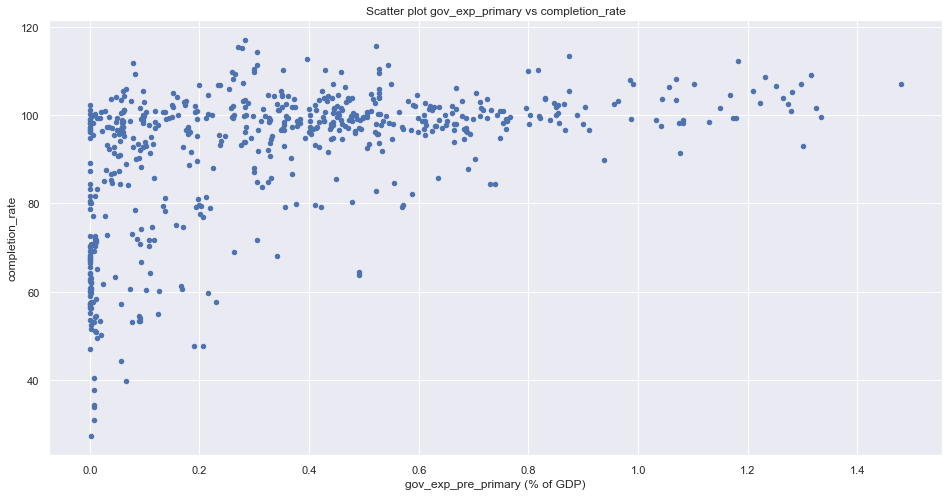

In [50]:
#scatter plot gov_exp_primary/completion_rate
df.plot.scatter(x='gov_exp_pre_primary (% of GDP)', y='completion_rate',  title="Scatter plot gov_exp_primary vs completion_rate");
plt.rcParams["figure.figsize"] = (16,8)

The visualization of the high correlation between gov_exp_pre_primary and completion rate looks interesting. We presume the goverment expenditure on pre-primary education prepares the kids to be good in primary school, and that has lasting effects. But the correlation is also appearant between exp on secondary aducation and completion_rate.

## Summary and important variables

Most important variables: gov_exp_pre_primary (% pf GDP), gov_exp_secondary (% pf GDP), oecd.

Does a country's spending on education influence the completion rate?

Yes, we can see that it does influence the completion rate. However, we were suprised that the expenditure on certain level of education doesn't necessery influence that education levels completion rate.

This is a complicated multivariate problem, that will be better understood when we combine the data sets together, and many of these small influences come together.

## Financing education data set description

Dimensions: 604 x 16

- **gov_exp_level (US dollars millions)** (Government expenditure on level of education, constant US dollars (millions))
    - *Total general (local, regional and central) government expenditure on level of education (current, capital, and transfers) in millions US dollars in constant value (taking into account inflation). It includes expenditure funded by transfers from international sources to government. Total government expenditure for a given level of education (e.g. primary, secondary, or all levels combined) in national currency is converted to US dollars, and where it is expressed in constant value, uses a GDP deflator to account for inflation. The constant prices base year is normally three years before the year of the data release. For example, in the July 2017 data release, constant US dollars values are expressed in 2014 prices. Limitations: In some instances data on total government expenditure on education refers only to the Ministry of Education, excluding other ministries which may also spend a part of their budget on educational activities.*
- **gov_exp_primary_per_person (US dollars)** (Government expenditure on primary education per person in country)
    - *gov_exp_level (US dollars millions) / population * 1000000*
- **gov_exp_level (% of GDP)** (Government expenditure on level of education, constant US dollars (millions))
    - *Total general (local, regional and central) government expenditure on level of education (current, capital, and transfers), expressed as a percentage of GDP. It includes expenditure funded by transfers from international sources to government. Divide total government expenditure for a given level of education (ex. primary, secondary, or all levels combined) by the GDP, and multiply by 100. A higher percentage of GDP spent on education shows a higher government priority for education, but also a higher capacity of the government to raise revenues for public spending, in relation to the size of the country's economy. When interpreting this indicator however, one should keep in mind in some countries, the private sector and/or households may fund a higher proportion of total funding for education, thus making government expenditure appear lower than in other countries. Limitations: In some instances data on total public expenditure on education refers only to the Ministry of Education, excluding other ministries which may also spend a part of their budget on educational activities.*
- **all_staff_compensation_primary** (All staff compensation as % of total expenditure in primary public institutions)
    - *All staff (teacher and non-teachers) compensation expressed as a percentage of direct expenditure in public educational institutions (instructional and non-instructional) on the primary level of education. Financial aid to students and other transfers are excluded from direct expenditure. Staff compensation includes salaries, contributions by employers for staff retirement programmes, and other allowances and benefits.*
- **oecd** (Organisation for Economic Co-operation and Development)
    - *The Organisation for Economic Co-operation and Development is an intergovernmental economic organisation with 38 member countries, founded in 1961 to stimulate economic progress and world trade. This column represents whether the country is in the organization (1) or not (0).*
- **gdp**
    - *GDP at purchaser's prices is the sum of gross value added by all resident producers in the economy plus any product taxes and minus any subsidies not included in the value of the products. It is calculated without making deductions for depreciation of fabricated assets or for depletion and degradation of natural resources. Data are in current U.S. dollars. Dollar figures for GDP are converted from domestic currencies using single year official exchange rates. For a few countries where the official exchange rate does not reflect the rate effectively applied to actual foreign exchange transactions, an alternative conversion factor is used.* 
- **population**
    - *	Total population is based on the de facto definition of population, which counts all residents regardless of legal status or citizenship. The values shown are midyear estimates.* 

## Main question answers

1. Which dataset(s) did you choose? 

We chose a base data set from the Education Statistics data from World Bank. We also downloaded the gdp and population data from World Development data from World Bank as well, to combine with the base data set.

2. Why? 

We chose this data set because after researching the internet, this data set covered the most countries, and had the most historic data. Also, it had the least missing values of the time span we wanted, which is something that we ran into a lot with country data in general. Another plus was that the World Bank had an online Query tool that helps us visualize, organize and download data.

3. How did you clean/transform the data? 

We cleaned the data using python and all of its helpful libraries. We imported the data sets, renamed the columns, drop the columns that had more than 90% of the data missing. We then also dropped the countries that had the most data missing, cleaned the missing values, maked sure that all the data is in the proper format, set data sets indexes the same in all different data sets, merged them into one.

4. Why? 

It was the most efficient and flexible way to clean the data.

5. How did you solve the problem of missing values? 

We researched quite a lot about missing data, especially in this context. In the end we concluded, that we would drop the columns and countries that had too many missing values, and then do hot-deck mean imputation. For a country that would have some value missing in a column, we would check if that country has the column data for other years, and if it does we would impute the other years mean into the missing values spot. Then, all the countries that were still left with the missing values, we did the following. We created 10 categories for countries, and we organized them by their gdp. If a country was missing a value in a certain columns, we would get the mean of that column from the other countries in its gdp category.

6. Why? 

First, we dropped the columns and years that had most of the data missing because it didn't make sense for us to fill ourselves 60%-70% of the data, as the data missing was huge. The data missing was nowhere to be found on the internet, because most of it wasn't recorded in the first place, or lost due to many different variables. We then did hot-deck imputation because the countries that had data from other years in the columns that had missing values, were always very similar. Imputing the mean would be almost as good as having the real data, as the fluctuations were tiny year to year. Then the hot deck imputation from a countries gdp category was a decent solution, as the countries usually spend similar on education.

7. What questions did you ask of the data? 

What variables are truly important for determining the completion_rate? Why?

8. Why were these good questions? 

Because, it made us really think of the correlation and influence between certain variables, and why would that make sense.

9. What were the answers to these questions? 

The gov_exp_pre_primary (% of GDP), gov_exp_secondary (% of GDP), oecd are variables had the most effect on the completion rate of primary school. Because the data clearly provides the evidence for it.

10. How did you obtain them? 

With data exploration on the final data set.

11. Do the answers make sense? 

Yes, and no. It was interesting that the goverment expenditure on pre-primary and secondary education had much bigger correlation withe the completion rate of children in primary school. The expenditure on pre primary education provides good foundation for childen and sets children up for primary school. The expenditure on secondary education can be explained that, if there is a high completion rate of children on a primary level, goverments invest more into secondary education so the continued education is not effected. But it was odd that the goverment expenditure on primary education didn't have a big effect on the completion rate. 

12. Were there any difficulties in analysing the data? 

Getting the data, and finding ways to get rid of so many missing values.

13. What were the key insights obtained? 

The gov_exp_pre_primary (% of GDP), gov_exp_secondary (% of GDP), oecd are variables had the most effect on the completion rate of primary school.

14. What are potential biases in the data and analysis? 

In the start, we thought that the low-income countries would be rare in the final data set, as they tend to have much less education historic data. Then the data set would be unbalanced. We are left with far more low-middle income countries that high income, but of course high income countries aren't many so that is how the distribution should be.

15. Which Data Science tools and techniques were learned during this exercise?

We've gotten a better grasp on the python an its libraries, especially seaborn that was used for the data exploration part. Also, we saw how it is to get really messy data from different data sources, clean it and make something out of it.